In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [18]:
data = pd.read_csv("C:/Users/user/Desktop/thesis_20240516/Vasicek_group1/vasicek_group1_portfolio1.csv", low_memory=False)

In [19]:
# Explicitly list the column names to be dropped
columns_to_drop = [
    'correlation', 
    'PD_700', 'Estimated_Loss_700',
    'PD_750', 'Estimated_Loss_750',
    'PD_800', 'Estimated_Loss_800',
    'PD_850', 'Estimated_Loss_850',
    'PD_900', 'Estimated_Loss_900',
    'PD_950', 'Estimated_Loss_950',
    'PD_990', 'Estimated_Loss_990',
    'PD_999', 'Estimated_Loss_999'
]

# Drop the columns
data = data.drop(columns=columns_to_drop)
df = data

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305524 entries, 0 to 1305523
Data columns (total 10 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   id               1305524 non-null  int64  
 1   exposure         1305524 non-null  float64
 2   grade            1305524 non-null  object 
 3   actual_class     1305524 non-null  int64  
 4   predicted_class  1305524 non-null  int64  
 5   uncon_PD         1305524 non-null  float64
 6   loss             1305524 non-null  float64
 7   issue_y          1305524 non-null  int64  
 8   issue_m          1305524 non-null  int64  
 9   loss_rate        1305524 non-null  float64
dtypes: float64(4), int64(5), object(1)
memory usage: 99.6+ MB


In [21]:
# Calculate the loss rate for each row
df['loss_rate'] = df['loss'] / df['exposure']

# Filter the dataset for rows where 'actual_class' is 1
subset_actual_class_1 = df[df['actual_class'] == 1]

# Calculate the weighted average loss rate for the entire dataset where 'actual_class' is 1
if not subset_actual_class_1.empty:  # Check if the subset is not empty
    weighted_avg_loss_rate_actual_class_1 = (subset_actual_class_1['loss_rate'] * subset_actual_class_1['exposure']).sum() / subset_actual_class_1['exposure'].sum()
    print("Weighted Average Loss Rate for entire dataset where actual_class is 1:")
    print(weighted_avg_loss_rate_actual_class_1)
else:
    print("No data for actual_class = 1.")


Weighted Average Loss Rate for entire dataset where actual_class is 1:
0.4680427557302783


In [22]:
# Define the correlation values for each grade
correlation_values = {
    'A': 0.0050115,
    'B': 0.0317056294136932,
    'C': 0.120492,
    'D': 0.1809156,
    'E': 0.3,
    'F': 0.3,
    'G': 0.3
}

# Add a new column 'correlation' by mapping the 'grade' column through the correlation_values dictionary
df['correlation'] = df['grade'].map(correlation_values)

# Check the output to verify the new column
print(df.head())


         id  exposure grade  actual_class  predicted_class  uncon_PD  loss  \
0  68407277    3600.0     C             0                0  0.321217   0.0   
1  68355089   24700.0     C             0                0  0.310668   0.0   
2  68341763   20000.0     B             0                0  0.179222   0.0   
3  68476807   10400.0     F             0                0  0.374441   0.0   
4  68426831   11950.0     C             0                0  0.245278   0.0   

   issue_y  issue_m  loss_rate  correlation  
0     2015       12        0.0     0.120492  
1     2015       12        0.0     0.120492  
2     2015       12        0.0     0.031706  
3     2015       12        0.0     0.300000  
4     2015       12        0.0     0.120492  


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305524 entries, 0 to 1305523
Data columns (total 11 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   id               1305524 non-null  int64  
 1   exposure         1305524 non-null  float64
 2   grade            1305524 non-null  object 
 3   actual_class     1305524 non-null  int64  
 4   predicted_class  1305524 non-null  int64  
 5   uncon_PD         1305524 non-null  float64
 6   loss             1305524 non-null  float64
 7   issue_y          1305524 non-null  int64  
 8   issue_m          1305524 non-null  int64  
 9   loss_rate        1305524 non-null  float64
 10  correlation      1305524 non-null  float64
dtypes: float64(5), int64(5), object(1)
memory usage: 109.6+ MB


In [24]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# Assuming 'df' is your original DataFrame
df_1 = df.copy()

# Define the confidence levels and their corresponding quantiles
confidence_levels = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 0.999]
quantiles = norm.ppf(confidence_levels)

# Vectorized calculation of PD at different confidence levels
uncon_PD_quantile = norm.ppf(df_1['uncon_PD'].values)
correlation = df_1['correlation'].values

for i, conf_level in enumerate(confidence_levels):
    pd_column_name = f'PD_{int(conf_level * 1000)}'
    quantile = quantiles[i]
    
    df_1[pd_column_name] = norm.cdf(
        (uncon_PD_quantile + quantile * np.sqrt(correlation)) / np.sqrt(1 - correlation)
    )

In [25]:
loss_rate = 0.4680
exposure = df_1['exposure'].values

for conf_level in confidence_levels:
    pd_column_name = f'PD_{int(conf_level * 1000)}'
    estimated_loss_column_name = f'Estimated_Loss_{int(conf_level * 1000)}'
    
    df_1[estimated_loss_column_name] = df_1[pd_column_name] * exposure * loss_rate

In [26]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305524 entries, 0 to 1305523
Data columns (total 27 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1305524 non-null  int64  
 1   exposure            1305524 non-null  float64
 2   grade               1305524 non-null  object 
 3   actual_class        1305524 non-null  int64  
 4   predicted_class     1305524 non-null  int64  
 5   uncon_PD            1305524 non-null  float64
 6   loss                1305524 non-null  float64
 7   issue_y             1305524 non-null  int64  
 8   issue_m             1305524 non-null  int64  
 9   loss_rate           1305524 non-null  float64
 10  correlation         1305524 non-null  float64
 11  PD_700              1305524 non-null  float64
 12  PD_750              1305524 non-null  float64
 13  PD_800              1305524 non-null  float64
 14  PD_850              1305524 non-null  float64
 15  PD_900         

In [27]:
# List of columns to calculate the sum
columns_to_sum = [
    'loss',
    'Estimated_Loss_700',
    'Estimated_Loss_750',
    'Estimated_Loss_800',
    'Estimated_Loss_850',
    'Estimated_Loss_900',
    'Estimated_Loss_950',
    'Estimated_Loss_990',
    'Estimated_Loss_999'
]

# Calculate the sums
sums = df_1[columns_to_sum].sum()

# Convert the series to a DataFrame for nicer display, and transpose it
sum_matrix = pd.DataFrame(sums).transpose()

# Rename index to 'Total Sum' for better understanding
sum_matrix.index = ["Total Sum"]

# Display the DataFrame
print(sum_matrix)

                   loss  Estimated_Loss_700  Estimated_Loss_750  \
Total Sum  1.924245e+09        2.385541e+09        2.529834e+09   

           Estimated_Loss_800  Estimated_Loss_850  Estimated_Loss_900  \
Total Sum        2.693262e+09        2.886284e+09        3.130945e+09   

           Estimated_Loss_950  Estimated_Loss_990  Estimated_Loss_999  
Total Sum        3.491849e+09        4.139377e+09        4.784689e+09  


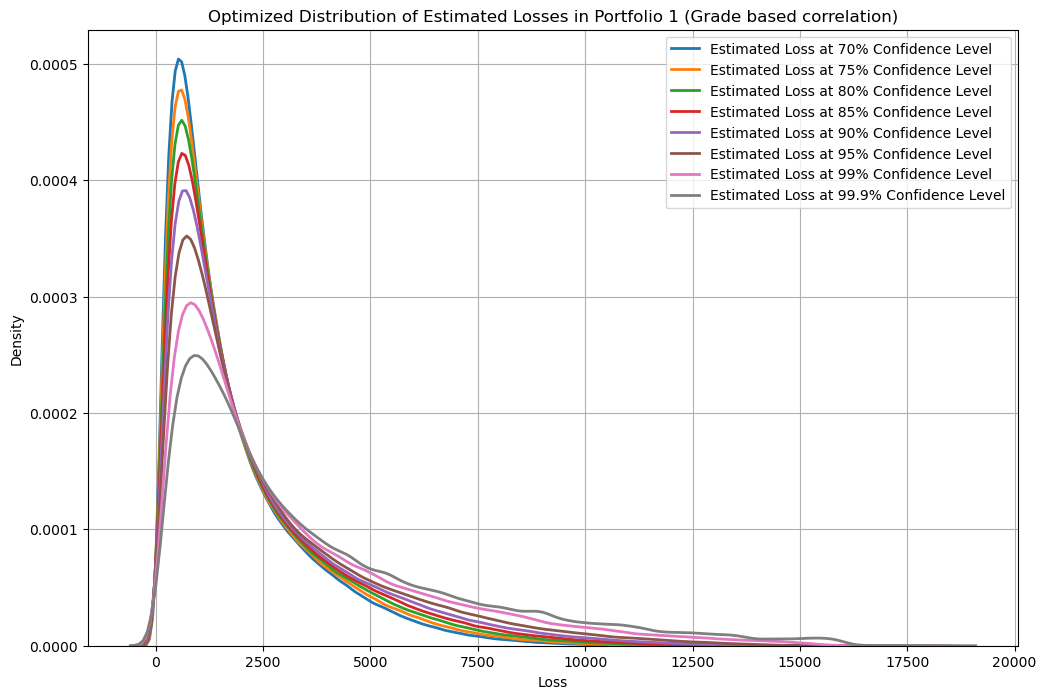

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure column names are stripped of any extra whitespace
df_1.columns = df_1.columns.str.strip()

# List of columns to plot
loss_columns = [
    'Estimated_Loss_700', 'Estimated_Loss_750', 'Estimated_Loss_800', 'Estimated_Loss_850',
    'Estimated_Loss_900', 'Estimated_Loss_950', 'Estimated_Loss_990', 'Estimated_Loss_999'
]

# Rename columns for clarity in the plot
column_names = {
    'Estimated_Loss_700': 'Estimated Loss at 70% Confidence Level',
    'Estimated_Loss_750': 'Estimated Loss at 75% Confidence Level',
    'Estimated_Loss_800': 'Estimated Loss at 80% Confidence Level',
    'Estimated_Loss_850': 'Estimated Loss at 85% Confidence Level',
    'Estimated_Loss_900': 'Estimated Loss at 90% Confidence Level',
    'Estimated_Loss_950': 'Estimated Loss at 95% Confidence Level',
    'Estimated_Loss_990': 'Estimated Loss at 99% Confidence Level',
    'Estimated_Loss_999': 'Estimated Loss at 99.9% Confidence Level'
}

# Plot the distributions
plt.figure(figsize=(12, 8))
for col in loss_columns:
    sns.kdeplot(df_1[col], label=column_names[col], linewidth=2)

plt.xlabel('Loss')
plt.ylabel('Density')
plt.title('Optimized Distribution of Estimated Losses in Portfolio 1 (Grade based correlation)')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Group the DataFrame by 'issue_year' and 'issue_month'
grouped = df_1.groupby(['issue_y', 'issue_m'])

# Initialize a dictionary to store results
results = {
    'loss': [],
    'Estimated_Loss_700': [],
    'Estimated_Loss_750': [], 
    'Estimated_Loss_800': [],
    'Estimated_Loss_850': [],
    'Estimated_Loss_900': [],
    'Estimated_Loss_950': [],
    'Estimated_Loss_990': [],
    'Estimated_Loss_999': []
}

# Calculate sums for each group
for name, group in grouped:
    for key in results.keys():
        results[key].append(group[key].sum())

# Convert to DataFrame for easier comparison
results_df = pd.DataFrame(results, index=grouped.size().index.rename(['Year', 'Month']))

# Frequency of actual loss sum exceeding estimated loss sums
frequencies = {}
for col in results_df.columns[1:]:  # Skip the first column which is 'loss'
    frequencies[col] = np.sum(results_df['loss'] > results_df[col])

frequencies

{'Estimated_Loss_700': 27,
 'Estimated_Loss_750': 25,
 'Estimated_Loss_800': 16,
 'Estimated_Loss_850': 15,
 'Estimated_Loss_900': 11,
 'Estimated_Loss_950': 2,
 'Estimated_Loss_990': 0,
 'Estimated_Loss_999': 0}

In [13]:
from scipy.stats import chi2
# Total number of trials (days)
n = 84
# Observed number of exceedances for each confidence level
exceedances = {'Estimated_Loss_700': 27,
 'Estimated_Loss_750': 25,
 'Estimated_Loss_800': 16,
 'Estimated_Loss_850': 15,
 'Estimated_Loss_900': 11,
 'Estimated_Loss_950': 2,
 'Estimated_Loss_990': 0,
 'Estimated_Loss_999': 0}

# Calculate Kupiec's test statistic and p-value for each confidence level
results = {}
for level, exceptions in exceedances.items():
    # Extract the numeric value from the level key
    confidence_percentage = int(level.split('_')[-1])
    # Calculate p from the confidence percentage
    p = (1000 - confidence_percentage) / 1000
    
    # Handle edge cases for log calculations
    p = max(p, 1e-10)  # prevent log(0)
    q = 1 - p
    q = max(q, 1e-10)  # prevent log(0)
    proportion = exceptions / n
    proportion = max(proportion, 1e-10)  # prevent log(0)
    one_minus_proportion = 1 - proportion
    one_minus_proportion = max(one_minus_proportion, 1e-10)  # prevent log(0)
    
    # Compute the components for the Kupiec test
    ln_part_model = (n - exceptions) * np.log(q) + exceptions * np.log(p)
    ln_part_actual = (n - exceptions) * np.log(one_minus_proportion) + exceptions * np.log(proportion)
    test_statistic = -2 * (ln_part_model - ln_part_actual)
    
    # Calculate the p-value
    p_value = chi2.sf(test_statistic, 1)  # survival function for chi-squared distribution

    # Store the results
    results[level] = {
        'Test Statistic': test_statistic,
        'p-value': p_value,
        'Model Accepted': p_value > 0.05
    }

results

{'Estimated_Loss_700': {'Test Statistic': 0.1812881343118704,
  'p-value': 0.6702685674295874,
  'Model Accepted': True},
 'Estimated_Loss_750': {'Test Statistic': 0.9771900239129252,
  'p-value': 0.32289353000655885,
  'Model Accepted': True},
 'Estimated_Loss_800': {'Test Statistic': 0.048200986570549276,
  'p-value': 0.8262237922779436,
  'Model Accepted': True},
 'Estimated_Loss_850': {'Test Statistic': 0.5121932790807762,
  'p-value': 0.474190940678308,
  'Model Accepted': True},
 'Estimated_Loss_900': {'Test Statistic': 0.8230595354642105,
  'p-value': 0.36428714556260045,
  'Model Accepted': True},
 'Estimated_Loss_950': {'Test Statistic': 1.492352441674857,
  'p-value': 0.22185182368281503,
  'Model Accepted': True},
 'Estimated_Loss_990': {'Test Statistic': 1.6884564065882424,
  'p-value': 0.19380457378326374,
  'Model Accepted': True},
 'Estimated_Loss_999': {'Test Statistic': 0.16808403924203238,
  'p-value': 0.6818202262657833,
  'Model Accepted': True}}